# Fomalhaut A's narrow ring
Multiple pointings... See splits.py for splits, statwt, and uv table creation. The alma package is in my github.

In [1]:
import os
import numpy as np
import emcee
import scipy.optimize
import scipy.signal
import matplotlib.pyplot as plt
import corner
import pymultinest as pmn
import galario.double as gd
from galario import arcsec

import alma.image

%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
# this may be needed to avoid emcee hanging when using multiple threads
gd.threads(num=1)

1

In [3]:
# import the data, this assumes we're getting the output from uvplot
uvdata = []
all_weights = np.array([])
wavelength = []
fw = []
nfield = 7
nspw = 4
for i in range(nfield):
    for j in range(nspw):
    
        f = 'uv-field{}-spw{}.txt'.format(i,j)

        u, v, Re, Im, w = np.require( np.loadtxt(f, unpack=True),requirements=["C_CONTIGUOUS"])

        # meaning we can get the mean wavelength like so
        with open(f) as tmp:
            _ = tmp.readline()
            tmp = tmp.readline()

        wavelength_tmp = float(tmp.strip().split('=')[1])    
        u /= wavelength_tmp
        v /= wavelength_tmp
        wavelength.append(wavelength_tmp)

        # estimate re-weighting factor (so that chi^2 for null model would be 1, and d.o.f = 2*len(w))
        # weights would need to be multiplied by this number
        fw.append( 2*len(w) / np.sum( (Re**2.0 + Im**2.0) * w ) )

        print('{}, {} rows, \twave {:9.7f}mm,'
              '\treweight factor {:g}'.format(os.path.basename(f),len(w),
                                              wavelength_tmp*1e3,
                                              fw[-1]))

        uvdata.append( (u, v, Re, Im, w) )
        all_weights = np.append(all_weights, w)

uv-field0-spw0.txt, 61719 rows, 	wave 1.2895492mm,	reweight factor 1.06829
uv-field0-spw1.txt, 60451 rows, 	wave 1.3945125mm,	reweight factor 1.08102
uv-field0-spw2.txt, 64977 rows, 	wave 1.3816599mm,	reweight factor 1.07403
uv-field0-spw3.txt, 64444 rows, 	wave 1.3004749mm,	reweight factor 1.11488
uv-field1-spw0.txt, 61719 rows, 	wave 1.2895492mm,	reweight factor 1.07609
uv-field1-spw1.txt, 60451 rows, 	wave 1.3945125mm,	reweight factor 1.08048
uv-field1-spw2.txt, 64977 rows, 	wave 1.3816599mm,	reweight factor 1.08579
uv-field1-spw3.txt, 64444 rows, 	wave 1.3004749mm,	reweight factor 1.10203
uv-field2-spw0.txt, 61719 rows, 	wave 1.2895492mm,	reweight factor 1.08786
uv-field2-spw1.txt, 60451 rows, 	wave 1.3945125mm,	reweight factor 1.06527
uv-field2-spw2.txt, 64977 rows, 	wave 1.3816599mm,	reweight factor 1.08737
uv-field2-spw3.txt, 64444 rows, 	wave 1.3004749mm,	reweight factor 1.0958
uv-field3-spw0.txt, 61223 rows, 	wave 1.2895492mm,	reweight factor 1.07221
uv-field3-spw1.txt, 59986 

In [4]:
# set image properties, take greatest resolution needed
nxy = 0
dxy = 1
for vis in uvdata:
    u, v, _, _, _ = vis
    nxy_tmp, dxy_tmp = gd.get_image_size(u, v, verbose=False)
    if nxy_tmp > nxy and dxy_tmp < dxy:
        nxy = nxy_tmp
        dxy = dxy_tmp
        
dxy_arcsec = dxy / arcsec
print('Final nxy:{}, dxy:{}, dxy arcsec:{}'.format(nxy, dxy, dxy_arcsec))

Final nxy:512, dxy:6.359884621383972e-07, dxy arcsec:0.13118203691836527


In [5]:
# decide what density model we want to use
model_name = 'peri_glow'

In [6]:
# make the image object, one will be used for all fields
# use an empirical pb from CASA, since it may matter here
ii = alma.image.Image(arcsec_pix=dxy_arcsec, image_size=(nxy, nxy), model='los_image',
                      dens_model=model_name, z_fact=1, wavelength=wavelength[0],
                      star=True, pb_fits='tmp.pb.fits')

Initial:[0, 0, 1.24226302]:170.77106461000074
Gaussian fit: final_simplex: (array([[0.00718415, 0.00359404, 1.24225559],
       [0.0071907 , 0.00359666, 1.24225598],
       [0.00718165, 0.00360256, 1.24225554],
       [0.00718065, 0.00358565, 1.24225625]]), array([170.76032856, 170.76032857, 170.76032857, 170.76032858]))
           fun: 170.76032856395804
       message: 'Optimization terminated successfully.'
          nfev: 100
           nit: 53
        status: 0
       success: True
             x: array([0.00718415, 0.00359404, 1.24225559])
model:los_image with density:peri_glow and emit:rj_tail
parameters are ['$x_0$', '$y_0$', '$\\Omega$', '$\\omega$', '$i$', '$F$', '$a_0$', '$\\sigma_a$', '$e_f$', '$i_f$', '$e_p$', '$\\sigma_{e,p}$', '$\\sigma_{i,p}$', '$F_{star}$']
rmax not set, run compute_rmax before generating images (may not apply to all density models)


In [7]:
# drop-in function for ii.image, with fixed image parameters
# star_fwhm is small since images are centered on 0,0
ii.image = lambda p: alma.image.eccentric_ring_image(p, nxy, dxy_arcsec, n=10000000, star_fwhm=0.1, da_gauss=False)

In [8]:
# create offset primary beam
def get_pb(ii, x0, y0):
    return ii.primary_beam_image(x0=x0, y0=y0)

In [9]:
# add weight factor to parameter list
ii.params += ['$f_{w}$']
ii.p_ranges += [[0,10]]
ii.n_params += 1

In [10]:
# need finite ranges for multinest, modify for problem at hand
ii.p_ranges[0] = [-0.1,0.1]
ii.p_ranges[1] = [-0.1,0.1]
ii.p_ranges[2] = [140,170]
ii.p_ranges[3] = [-20,60]
ii.p_ranges[4] = [50,80]
ii.p_ranges[5] = [0.01,0.1]
ii.p_ranges[6] = [10,25]
ii.p_ranges[7] = [0,3]
# ii.p_ranges[9] = [0,0.005]   #
# ii.p_ranges[11] = [0,0.005]  # for flat MacGregor model
# ii.p_ranges[12] = [0,0.005]  #
ii.p_ranges[13] = [0,0.0015]

In [11]:
# offsets in x, y (i.e. -ra, dec), delta RA are (a-b)*15*cos(dec)
# we assume the pointing is good and that these are fixed
# (but can all move relative to some center together)
off = [0.0, 0.0,                # field 0
       -8.898409, -19.98620,    # field 1 relative to 0
       +8.898396, +19.98620,    # 2 relative etc.
       +10.22100,  +7.42670,    # 3
        -1.32100, +12.56580,    # 4
        +1.32100, -10.93879,    # 5
       -10.22100,  -7.42670]    # 6

# pericentre glow model
p0 = [-0.06542785156837794,0.048660868203270105,156.37496611018472,40.74382055684831,66.64319590251502,
      0.026595648373342343,18.173138876150325,1.5,0.1238431709670846,0.0025,
      0.06,0.0025,0.0025,0.000673553452336449, 1]

p0 = np.array(p0)

print('parameters and ranges for {}'.format(model_name))
for i in range(ii.n_params):
    print('{}\t{}\t{}\t{}'.format(i,p0[i],ii.p_ranges[i],ii.params[i]))

parameters and ranges for peri_glow
0	-0.06542785156837794	[-0.1, 0.1]	$x_0$
1	0.048660868203270105	[-0.1, 0.1]	$y_0$
2	156.37496611018472	[140, 170]	$\Omega$
3	40.74382055684831	[-20, 60]	$\omega$
4	66.64319590251502	[50, 80]	$i$
5	0.026595648373342343	[0.01, 0.1]	$F$
6	18.173138876150325	[10, 25]	$a_0$
7	1.5	[0, 3]	$\sigma_a$
8	0.1238431709670846	[0.0, 0.5]	$e_f$
9	0.0025	[0.0, 0.5]	$i_f$
10	0.06	[0.0, 0.5]	$e_p$
11	0.0025	[0.0, 0.5]	$\sigma_{e,p}$
12	0.0025	[0.0, 0.5]	$\sigma_{i,p}$
13	0.000673553452336449	[0, 0.0015]	$F_{star}$
14	1.0	[0, 10]	$f_{w}$


In [12]:
# set size of cutout used to generate images, which is based on the
# initial parameters. The tolerance in compute_rmax might be
# varied if the crop size turns out too large. We set 'zero_node'
# to True because we'll generate unrotated images, and let galario
# do the rest
# ii.compute_rmax(np.append([0, 0], p0[14:]), tol=1e-2, expand=10, zero_node=False)

# this gives an idea of how long an mcmc might take
# %timeit ii.image(p0)

# show an image and the primary beam
im = ii.image(p0)
fig,ax = plt.subplots(1,3, figsize=(9.5,5), sharey=True, sharex=True)
ax[0].imshow(im, origin='bottom', vmax=np.percentile(im, 99.9))
ax[1].imshow(get_pb(ii,0,0), origin='bottom')
ax[2].imshow(im*get_pb(ii,0,0), origin='bottom', vmax=np.percentile(im, 99.9))
fig.tight_layout()

<IPython.core.display.Javascript object>

In [13]:
# sanity check on field offsets
fig,ax = plt.subplots(2,4, figsize=(9.5,5), sharey=True, sharex=True)
for i in range(nfield):
    tmp = np.append([(p0[0]-off[2*i]), (p0[1]-off[2*i+1])],p0[2:])
    im = ii.image(tmp)
    ax[np.unravel_index(i,ax.shape)].imshow(im * get_pb(ii,0,0), origin='bottom', vmax=np.percentile(im,99))
    ax[np.unravel_index(i,ax.shape)].contour(im, origin='lower', alpha=0.5)
    ax[np.unravel_index(i,ax.shape)].set_title('field {}'.format(i))
    ax[np.unravel_index(i,ax.shape)].plot(nxy/2, nxy/2, '+')
    
fig.tight_layout()

<IPython.core.display.Javascript object>

In [14]:
# sanity check on pb offsets
fig,ax = plt.subplots(2,4, figsize=(9.5,5), sharey=True, sharex=True)
tmp = np.append([0,0],p0[2:])
image = ii.image(tmp)
for i in range(nfield):
    x0, y0 = p0[0]-off[2*i], p0[1]-off[2*i+1]
    pb = get_pb(ii, -x0, -y0)
    ax[np.unravel_index(i,ax.shape)].imshow(image * pb, origin='bottom', vmax=np.percentile(image,99))
    ax[np.unravel_index(i,ax.shape)].set_title('field {}:{:5.2f},{:5.2f}'.format(i,x0,y0))
    ax[np.unravel_index(i,ax.shape)].plot(nxy/2-x0/dxy_arcsec, nxy/2-y0/dxy_arcsec, '+w')
    
fig.tight_layout()

<IPython.core.display.Javascript object>

In [15]:
def lnpostfn(p, return_chi2=False):
    """ Log of posterior probability function """

    for x,r in zip(p,ii.p_ranges):
        if x < r[0] or x > r[1]:
            return -np.inf

    # images, star-centered with offset primary beam (i.e. second e.g. above), shifted by galario
    chi2 = 0.0
    tmp = np.append([0,0],p[2:-1])
    image = ii.image(tmp)
    for i in range(nfield):
        x0, y0 = p[0]-off[2*i], p[1]-off[2*i+1]
        pb = get_pb(ii, -x0, -y0)
        for j in range(nspw):
            u, v, Re, Im, w = uvdata[i*nspw + j]
            chi2_tmp = gd.chi2Image(image*pb , dxy, u, v, Re, Im, w, origin='lower',
                                    dRA = -x0*arcsec, dDec = y0*arcsec)
            chi2 += chi2_tmp

    if return_chi2:
        return chi2

    # we include a weight factor to force reasonable uncertainties
    return -0.5 * ( chi2*p[-1] + np.sum(2*np.log(2*np.pi/(all_weights*p[-1]))) )

nlnpostfn = lambda p: -lnpostfn(p)

In [17]:
# check it works
lnpostfn(p0)

11230173.338311711

### multinest fitting

In [22]:
# where results go
pmn_out = 'multinest_da_flat/'
model_name = pmn_out[:-1]

def mn_prior(cube, ndim, nparam):
    pars = ii.p_ranges
    for i in range(ndim):
        cube[i] = pars[i][0] + cube[i] * (pars[i][1]-pars[i][0])

def mn_lnlike(cube, ndim, nparam):  
    param = np.array([])
    for i in range(ndim):
        param = np.append(param,cube[i])
    return lnpostfn(param)

In [ ]:
# run it (call python script of this notebook with >nice -11 mpiexec -n 40 python3 vis_model_mn.py)
pmn.run(mn_lnlike, mn_prior, ii.n_params, n_live_points=75, verbose=True,
        outputfiles_basename=pmn_out, multimodal=True)

ERROR: Interrupt received: Terminating


In [23]:
# output, start here if multinest was run outside this notebook
a = pmn.Analyzer(outputfiles_basename=pmn_out, n_params=ii.n_params)
# print(a.get_stats())

p = [a.get_stats()['marginals'][i]['median'] for i in range(ii.n_params)]
print(p)
print(lnpostfn(p, return_chi2=True))

for i in range(ii.n_params):
    print('{}\t{:g}\t{:g}\t{:g}\t{:g}'.format(ii.params[i],
                                      a.get_stats()['marginals'][i]['median'], 
                                      p[i]-a.get_stats()['marginals'][i]['1sigma'][0], 
                                      a.get_stats()['marginals'][i]['1sigma'][1]-p[i], 
                                      a.get_stats()['marginals'][i]['3sigma'][1])
         )

  analysing data from multinest_da_flat/.txt
[-0.06284050983240964, 0.03298298309284629, 156.3891947452942, 40.83360014670932, 66.68201901005321, 0.024457782791749608, 18.190790207135883, 2.0926939962334368, 0.12652773624572114, 0.0026763681550120346, 0.050569294089493746, 0.002974367979661281, 0.002713799640844707, 0.000664273542327087, 1.0944553879797232]
3192877.902581249
$x_0$	-0.0628405	0.00953158	0.00907367	-0.0294003
$y_0$	0.032983	0.00844791	0.00829913	0.0571482
$\Omega$	156.389	0.0333351	0.0351024	156.489
$\omega$	40.8336	0.566521	0.540267	42.5353
$i$	66.682	0.0329641	0.0408039	66.7864
$F$	0.0244578	0.000158462	0.000168983	0.0249926
$a_0$	18.1908	0.0125944	0.0113129	18.2263
$\sigma_a$	2.09269	0.064339	0.0638015	2.25729
$e_f$	0.126528	0.00119736	0.00110968	0.130326
$i_f$	0.00267637	0.00168777	0.00167889	0.00497508
$e_p$	0.0505693	0.00122796	0.00120225	0.0538211
$\sigma_{e,p}$	0.00297437	0.0018581	0.00143227	0.00499759
$\sigma_{i,p}$	0.0027138	0.00184155	0.00153519	0.00499279
$F

In [63]:
a.get_stats()

{'modes': [{'index': 0,
   'strictly local log-evidence': 11237319.215353923,
   'strictly local log-evidence error': 0.017075150616123146,
   'local log-evidence': 11237319.215353923,
   'local log-evidence error': 0.017075150616123146,
   'mean': [-0.06629684606467688,
    0.03628067756044352,
    156.3433160671725,
    40.80007456120021,
    66.64523908026732,
    0.026406103500167713,
    18.17705042699298,
    0.08644957720265932,
    0.1255012704401572,
    0.06710019871613176,
    0.018269777266250804,
    0.08952145022998365,
    0.03815824091697777,
    0.000662586718143108,
    1.094476678459673],
   'sigma': [0.010831815699231544,
    0.008315683965313443,
    0.03728588127998506,
    0.6517262375392995,
    0.05219065235543054,
    0.00023872884696845428,
    0.036006367593575166,
    0.05977184267741908,
    0.0011544105391012116,
    0.046322288753007326,
    0.004341025629858173,
    0.0022935187846226104,
    0.024207401536183407,
    1.1584676310806458e-05,
    0.00082

In [64]:
# alter sigma_a to delta_a if needed for plot
ii.params[7] = '$\\sigma_a$'
# ii.params[7] = '$\\delta_a$'
ii.params

['$x_0$',
 '$y_0$',
 '$\\Omega$',
 '$\\omega$',
 '$i$',
 '$F$',
 '$a_0$',
 '$\\sigma_a$',
 '$e_f$',
 '$i_f$',
 '$e_p$',
 '$\\sigma_{e,p}$',
 '$\\sigma_{i,p}$',
 '$F_{star}$',
 '$f_{w}$']

In [65]:
fs = 19
plt.rcParams.update({'font.size': fs})

<IPython.core.display.Javascript object>


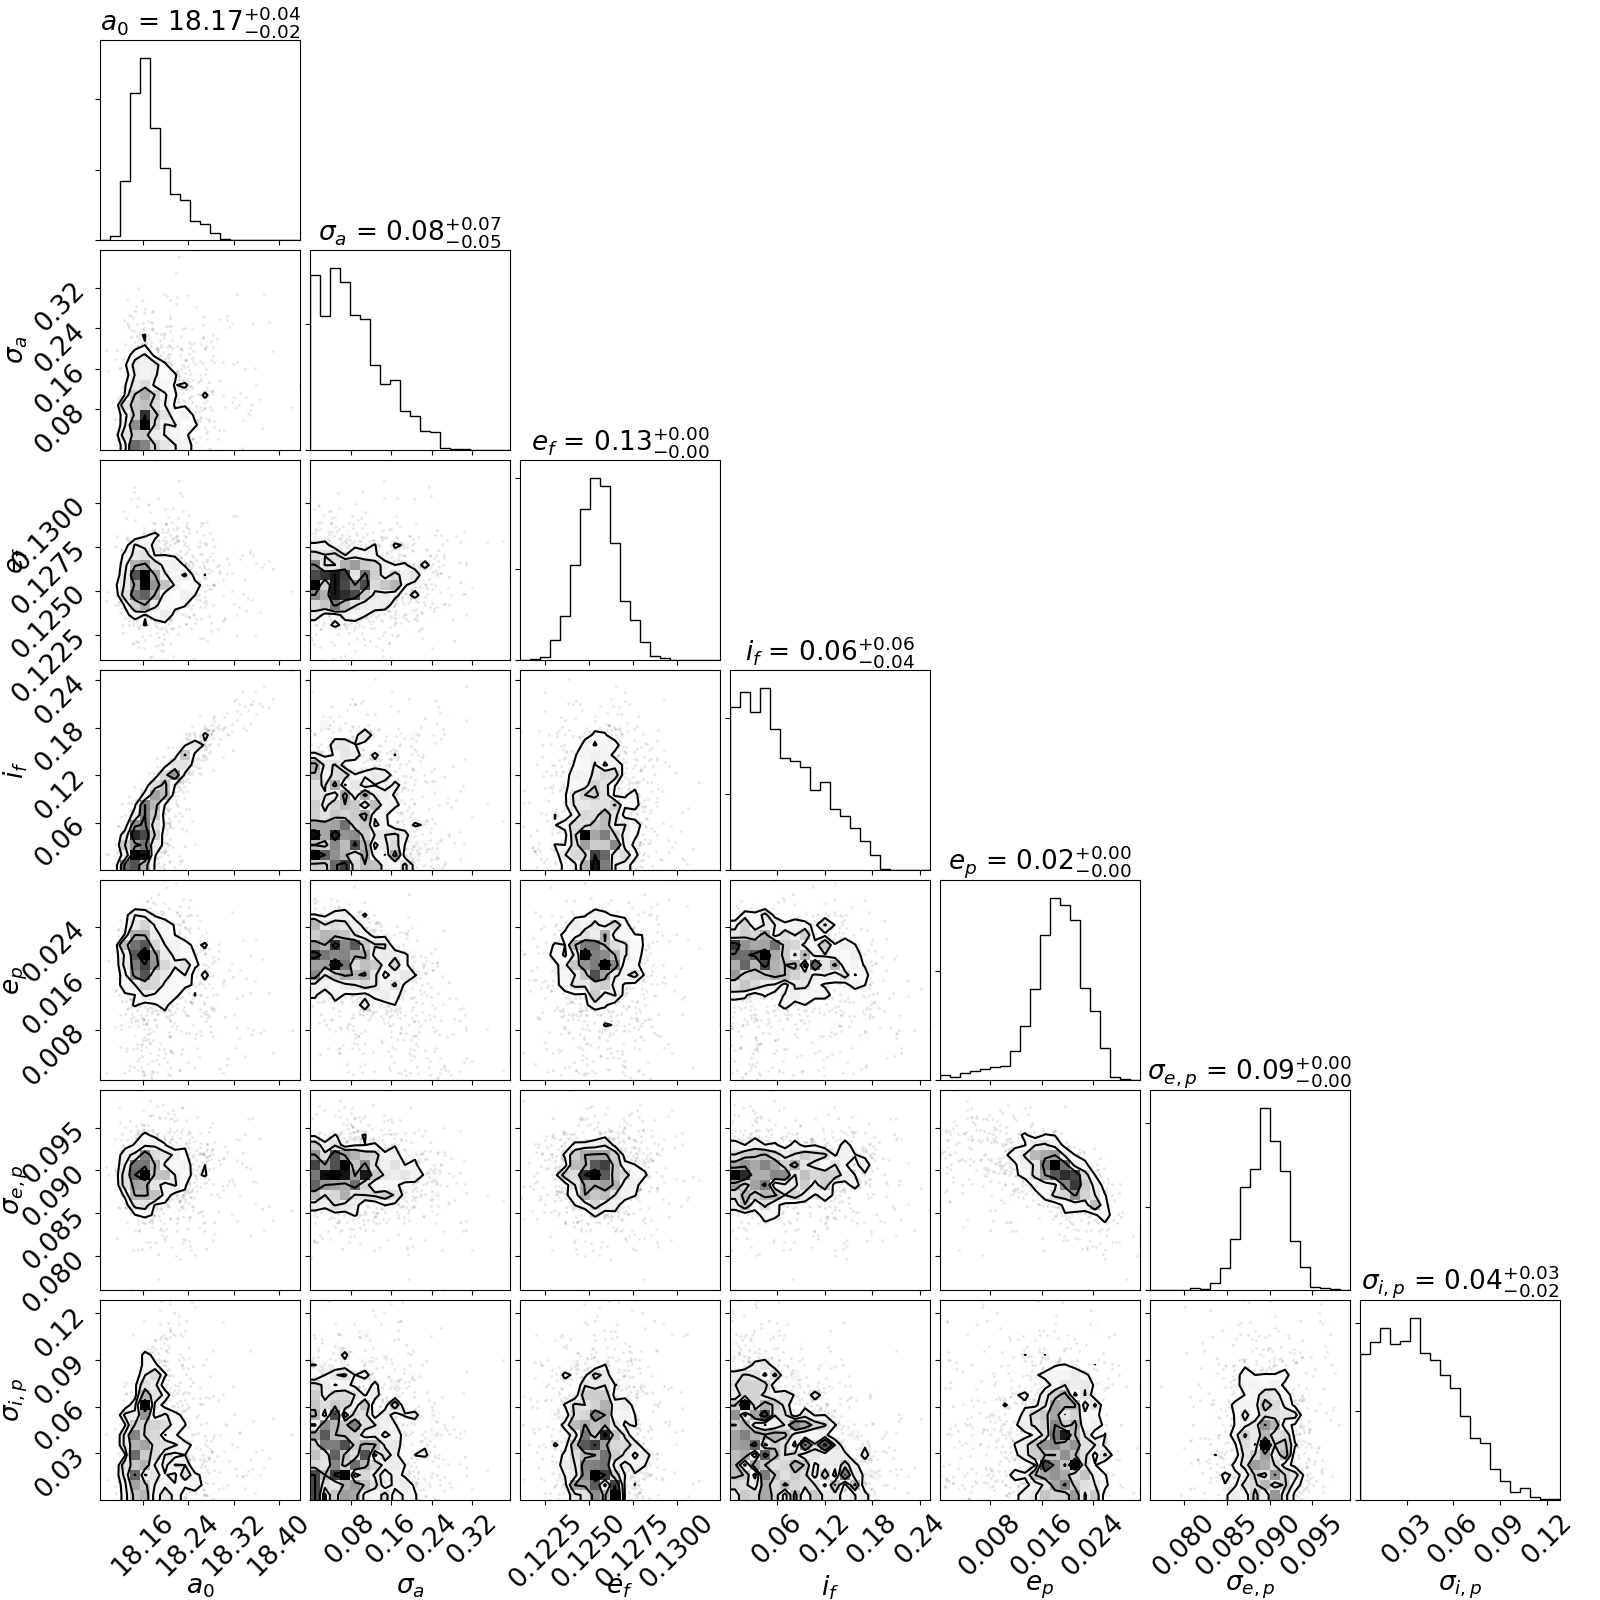

In [67]:
# corner plot
d = a.get_data()
mask = d[:,0] > 1e-8
# fiddle these to plot what we want    x   x x
keep = np.array([0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0],dtype=bool)
fig = corner.corner(d[mask][:,keep], weights=d[mask,0], labels=np.array(ii.params)[keep[2:]],
                    show_titles=True, title_kwargs={"fontsize": fs},
                    label_kwargs={"fontsize": fs})

ax = fig.get_axes()
for a1 in ax:
    x, y = a1.xaxis.label.get_position()
    a1.xaxis.label.set_position((x,y-0.07))
    x, y = a1.yaxis.label.get_position()
    a1.yaxis.label.set_position((x-0.05,y))

fig.savefig('{}corner.pdf'.format(pmn_out))

### emcee fitting
(which wasn't used for the paper)

In [25]:
# set up and run mcmc fitting
ndim = ii.n_params        # number of dimensions
nwalkers = 28             # number of walkers
nsteps = 10              # total number of MCMC steps
nthreads = 4              # CPU threads that emcee should use

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpostfn, threads=nthreads)

# initialize the walkers with an ndim-dimensional Gaussian ball
pos = [p0 + p0*0.05*np.random.randn(ndim) for i in range(nwalkers)]

# execute the MCMC
pos, prob, state = sampler.run_mcmc(pos, nsteps)

In [27]:
print(sampler.acceptance_fraction)

[ 0.4  0.2  0.2  0.3  0.4  0.4  0.3  0.4  0.4  0.4  0.   0.5  0.1  0.4  0.1
  0.3  0.3  0.4  0.3  0.2  0.4  0.3  0.4  0.2  0.2  0.2  0.3  0.2]


In [29]:
# save the chains to file
model_name = 'emcee_full'
np.savez_compressed(model_name+'/chains-'+model_name+'.npz', sampler.chain, sampler.lnprobability)

In [16]:
# load chains, start here if emcee was run outside this notebook
with np.load(model_name+'/chains-'+model_name+'.npz') as data:
    chain = data['arr_0']
    lnprobability = data['arr_1']

In [17]:
nwalkers, nsteps, ndim = chain.shape
print(chain.shape)

(176, 1000, 14)


<IPython.core.display.Javascript object>


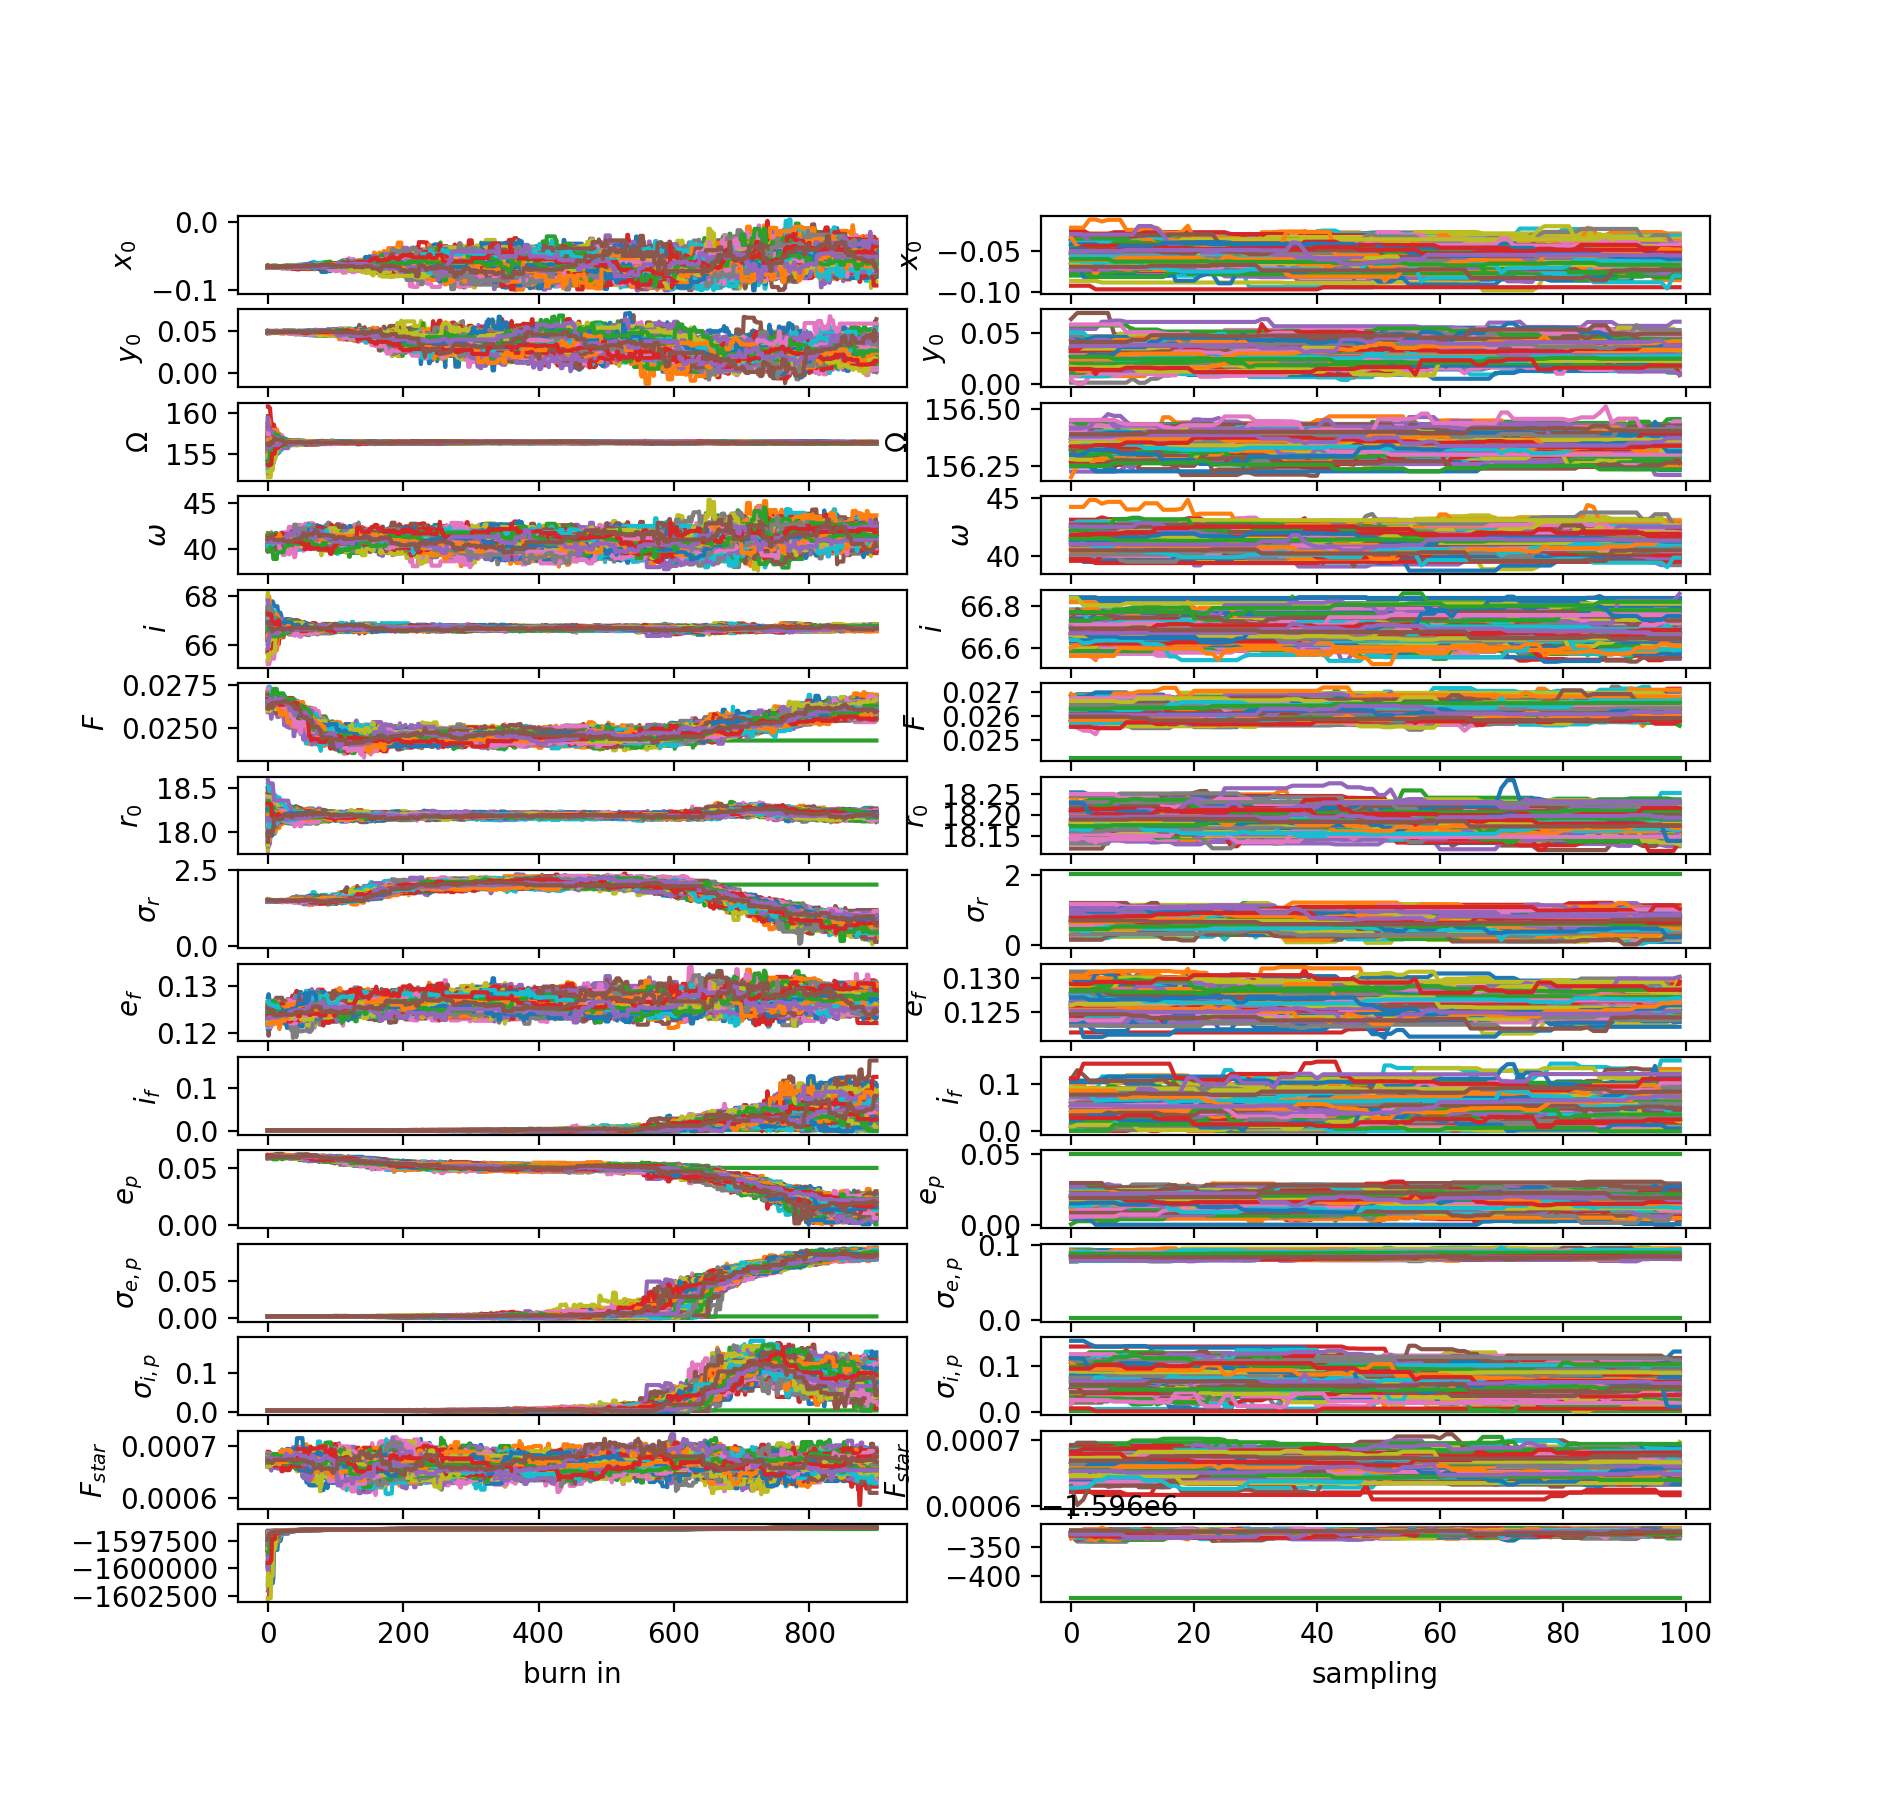

In [18]:
# see what the chains look like, skip a burn in period if desired
burn = 900
fig,ax = plt.subplots(ndim+1,2,figsize=(9.5,9),sharex='col',sharey=False)

for j in range(nwalkers):
    ax[-1,0].plot(lnprobability[j,:burn])
    for i in range(ndim):
        ax[i,0].plot(chain[j,:burn,i])
        ax[i,0].set_ylabel(ii.params[i])

for j in range(nwalkers):
    ax[-1,1].plot(lnprobability[j,burn:])
    for i in range(ndim):
        ax[i,1].plot(chain[j,burn:,i])
        ax[i,1].set_ylabel(ii.params[i])

ax[-1,0].set_xlabel('burn in')
ax[-1,1].set_xlabel('sampling')
fig.savefig(model_name+'/chains-'+model_name+'.pdf')

<IPython.core.display.Javascript object>


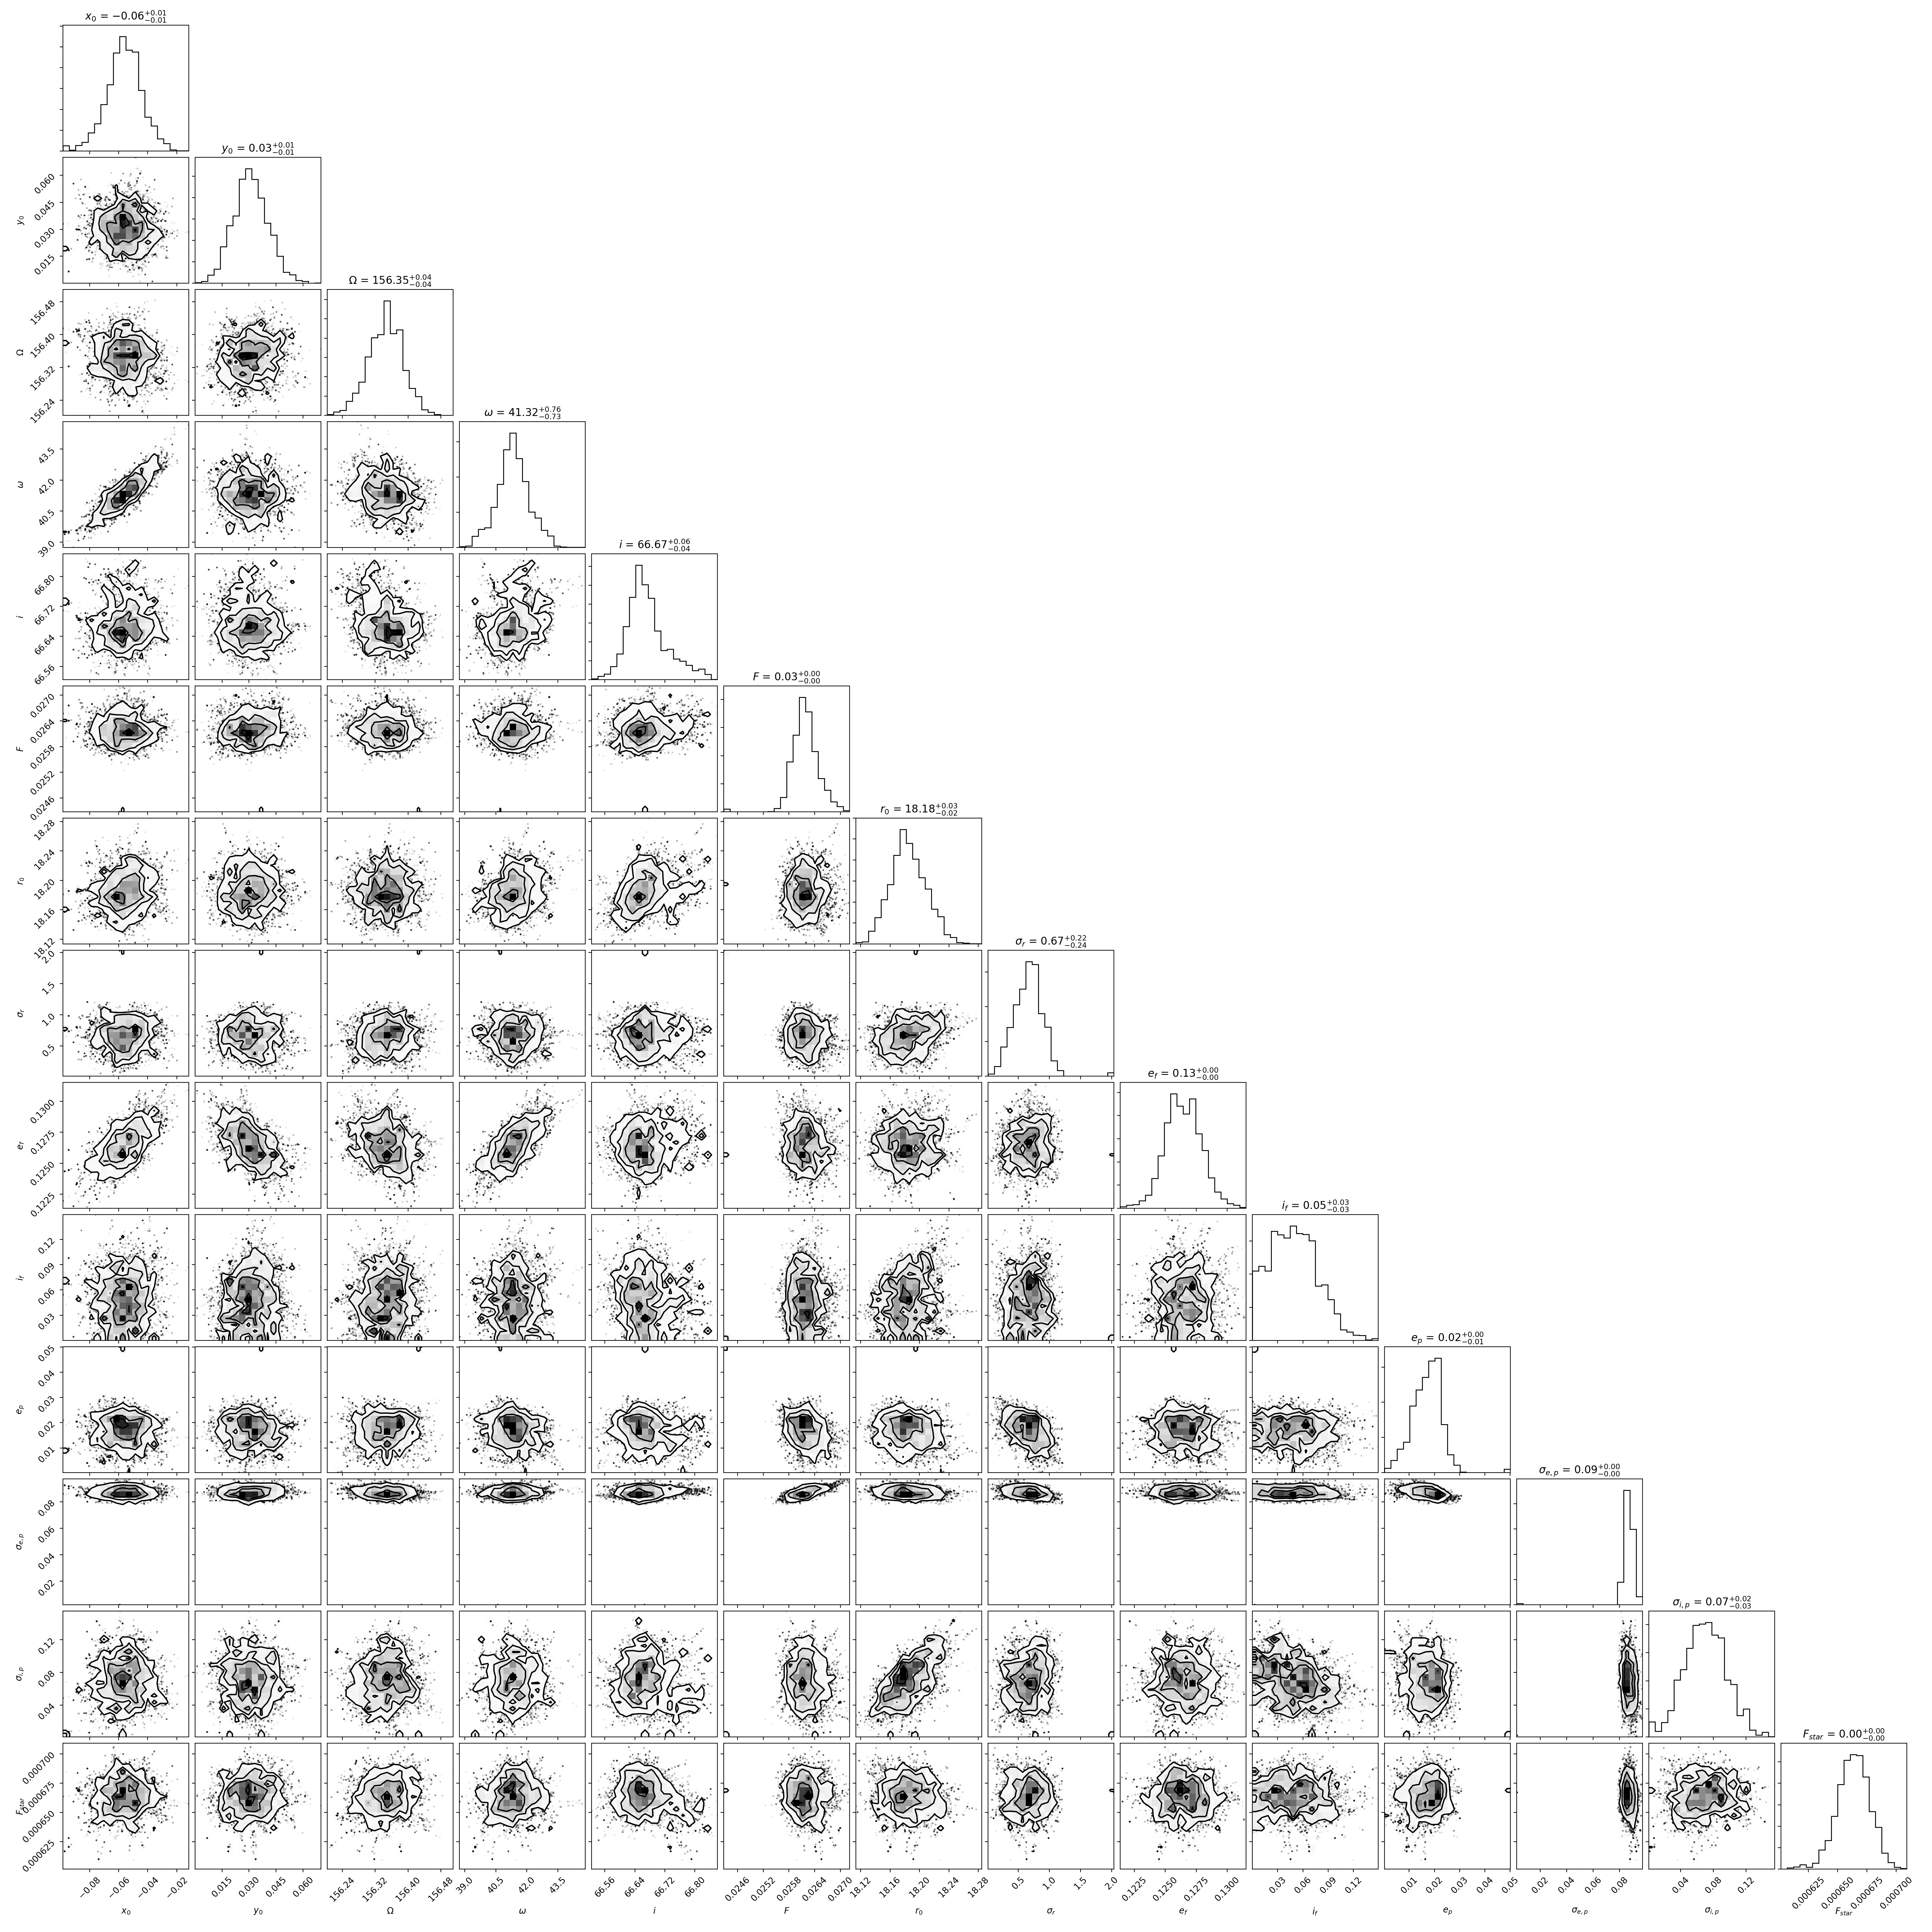

In [19]:
# make the corner plot
fig = corner.corner(chain[:,burn:,:].reshape((-1,ndim)), labels=ii.params,
                    show_titles=True)

fig.savefig(model_name+'/corner-'+model_name+'.pdf')

In [19]:
# get the median parameters
p = np.median(chain[:,burn:,:].reshape((-1,ndim)),axis=0)
s = np.std(chain[:,burn:,:].reshape((-1,ndim)),axis=0)
print(','.join(p.astype(str)))
print(s)

-0.06289910681452765,0.04923000713582472,156.39416763803595,40.68446756524981,66.71389616090181,0.024539256329651052,18.190690776866454,2.1236908317311087,0.1244640389921549,0.002626189586666195,0.050505249163806616,0.002617583342799003,0.0024953096305894086,0.0006784067148779584
[1.20915897e-02 9.86724521e-03 4.72675959e-02 7.58394115e-01
 4.75421263e-02 2.11089341e-04 1.66521639e-02 7.61752279e-02
 1.30691903e-03 1.38958853e-03 1.34384963e-03 1.51017568e-03
 1.47433071e-03 1.42841190e-05]


### post-fitting stuff (regardless of fitting method)

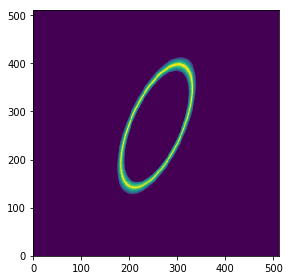

In [20]:
# see what it looks like
im = ii.image(p)
fig,ax = plt.subplots()
ax.imshow(im, origin='bottom', vmax=np.percentile(im, 99.9))
fig.tight_layout()
fig.savefig(model_name+'/best-'+model_name+'.pdf', dpi=500)

In [21]:
# save the visibilities for subtraction from the data
tmp = np.append([0,0],p[2:-1])
image = ii.image(tmp)
for i in range(nfield):
    x0, y0 = p[0]-off[2*i], p[1]-off[2*i+1]
    pb = get_pb(ii, -x0, -y0)
    for j in range(nspw):
        u, v, Re, Im, w = uvdata[i*nspw + j]
        vis_mod = gd.sampleImage(image * pb, dxy, u, v, origin='lower', dRA = -x0*arcsec, dDec = y0*arcsec)
        np.save(model_name+'/vis-{}-field{}-spw{}.npy'.format(model_name, i, j), vis_mod)

## Creating a map of the residuals
See splits.py